In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
sys.path.insert(0, '/home/edlitzy/PycharmProjects/UKBB_p3/Article_files/')
sys.path.insert(0, "/home/edlitzy/PycharmProjects/UKBB_p3/")
from UKBB_article_plots_config import *
from UKBB_article_plots_functions import *
from UKBB_Scoreboard_functions import *
# from tqdm import tqdm
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def load_labels(Score_board,y_file_name,curr_folder,mode="explore",return_results=True):
    scores=Score_board.calc_scores(mode=mode,return_results=return_results)
    scores.index=scores.index.astype(str)
    df=pd.read_csv(os.path.join(curr_folder,y_file_name),index_col=0)
    df.index=df.index.astype(str)
#     if "eid" in val_scores.index and val_scores.index.name == "eid":
#     val_scores.drop("eid",inplace=True)
    scores.name="y_pred"
    df.columns=["y_test"]
    df.index.name="eid"
    df=df.join(scores,how="left")
    pred_col="y_pred"
    df=df.astype(float)
    df = df.sort_values(pred_col, ascending=False)
    return scores,df

# val_scores.loc[val_df.index.astype(str),"y_pred"]=val_df.values


In [27]:
def calc_ci(rank1K):
    q25=rank1K[["Ratio","Boundaries"]].groupby("Boundaries").quantile(0.025)
    q975=rank1K[["Ratio","Boundaries"]].groupby("Boundaries").quantile(0.975)
    qmean=rank1K[["Ratio","Boundaries"]].groupby("Boundaries").mean()
    stats_df=pd.concat([qmean,q25,q975],axis=1)
    stats_df.columns=["mean","0.0275","0.975"]
    stats_df = stats_df.applymap(lambda x: '{0:.3f}'.format(x) if x<0.01 else '{0:.2f}'.format(x))
    stats_df["CI"]=stats_df["mean"]+" ["+stats_df["0.0275"]+"-"+stats_df["0.975"]+"]"
    stats_df.reset_index(inplace=True)
    stats_df["Legend"]=stats_df["Boundaries"]+" "+stats_df["CI"]
    return stats_df

# Explore folders

In [28]:
base_path="/net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/"
results_path=os.path.join(base_path,"results_folder/") # save_to_scoreboards_basic_path
folders=[x for x in os.listdir(base_path) if os.path.isdir(os.path.join(base_path,x))]
folders

['SA',
 'stratified',
 'clalit',
 'compare_addings_LR',
 'final_figures',
 'figures',
 'Compare_singles_LR',
 'bu',
 'explore',
 'results_folder',
 'LR_Antro_neto_whr',
 'Singles_GBDT',
 'compare_addings_DT',
 'Tables']

# Test for Four_blood_tests

## Recover relevant scoreboard

In [29]:
scoreboard_type="No_reticulocytes_scoreboard"
# run_name="LR_No_reticulocytes_scoreboard"

sb=recover_scoreboard(scoreboard_type=scoreboard_type,
                      save_to_scoreboards_basic_path=results_path,
                      base_path=base_path)

sb.woe_csv_path=os.path.join(results_path,sb.run_name,"summary_files/woe_csv.csv")
sb.save_to_folder=os.path.join(results_path,sb.run_name)
sb.summary_folder=os.path.join(results_path,sb.run_name,"summary_files/")

Factor: 14.43 Offset: 43.56
('Running in ', None, ' mode')
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/ exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_No_reticulocytes_scoreboard/training_Results exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_No_reticulocytes_scoreboard/CI exists
('Running in ', None, ' mode')
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/ exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_No_reticulocytes/training_Results exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_No_reticulocytes/CI exists
Loading ScoreBoard No_reticulocytes_scoreboard  from  /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_No_reti

## Load Scores and labels

In [30]:
curr_folder=os.path.join(base_path,"results_folder", sb.run_name)
val_df,val_scores=load_labels(sb,y_file_name="y_LR_val.csv",curr_folder=curr_folder,mode="explore",return_results=True)
test_df,test_scores=load_labels(sb,y_file_name="y_LR_test.csv",curr_folder=curr_folder,mode=None,return_results=True)

## Investigate validation df bins

In [31]:
n_bins=100
res=1./n_bins
quants_bins=[0.8,0.9,0.995,1]
val_Rank_df=pd.DataFrame()
val_Rank_df=calc_Rank_df(val_scores, quants_bins=quants_bins, prevalence_thresh_fold=None,pred_col="y_pred")
val_Rank_df

,quantile number,Lower Boundary,upper Boundary,Diagnosed,All,Ratio,Fold
0,1,0.0,104.0,50.0,8639.0,0.005788,1.000000
1,2,104.0,116.0,31.0,1026.0,0.030214,5.220448
2,3,116.0,146.0,113.0,1017.0,0.111111,19.197778
3,4,146.0,162.0,12.0,42.0,0.285714,49.365714


In [32]:
boundaries=[0]
boundaries.extend(val_Rank_df.loc[:,["upper Boundary"]].values.flatten().tolist())
val_rank_list=[]
for ind in np.arange(1000):
    sampled_val_scores=val_scores.sample(n=val_scores.shape[0],replace=True)
    val_rank_list.append(test_rank_df(sampled_val_scores, boundaries=boundaries,pred_col="y_pred"))
val_rank1K=pd.concat(val_rank_list)
val_rank1K["Boundaries"]=(val_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+val_rank1K["upper Boundary"].astype(int).astype(str)
val_rank1K.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(val_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_results.csv"))
new_stats_df

,mean,0.0275,0.975,CI,Legend
Boundaries,,,,,
1-104,0.006,0.004,0.007,0.006 [0.004-0.007],1-104 0.006 [0.004-0.007]
105-116,0.03,0.02,0.04,0.03 [0.02-0.04],105-116 0.03 [0.02-0.04]
117-146,0.11,0.09,0.13,0.11 [0.09-0.13],117-146 0.11 [0.09-0.13]
147-162,0.29,0.15,0.44,0.29 [0.15-0.44],147-162 0.29 [0.15-0.44]


## Get the bins results of the test

In [33]:
test_rank_list=[]
for ind in np.arange(1000):
    sampled_test_scores=test_scores.sample(n=test_scores.shape[0],replace=True)
    test_rank_list.append(test_rank_df(sampled_test_scores, boundaries=boundaries,pred_col="y_pred"))

In [34]:
test_rank1K=pd.concat(test_rank_list)
test_rank1K["Boundaries"]=(test_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+test_rank1K["upper Boundary"].astype(int).astype(str)
test_rank1K.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(test_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_results.csv"))

In [35]:
os.path.join(curr_folder,base_path,"scoreborad_groups_results.csv")

'/net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/scoreborad_groups_results.csv'

In [36]:
new_stats_df

,mean,0.0275,0.975,CI,Legend
Boundaries,,,,,
1-104,0.005,0.004,0.007,0.005 [0.004-0.007],1-104 0.005 [0.004-0.007]
105-116,0.03,0.02,0.04,0.03 [0.02-0.04],105-116 0.03 [0.02-0.04]
117-146,0.10,0.08,0.12,0.10 [0.08-0.12],117-146 0.10 [0.08-0.12]
147-162,0.23,0.11,0.37,0.23 [0.11-0.37],147-162 0.23 [0.11-0.37]


## Plot whiskers

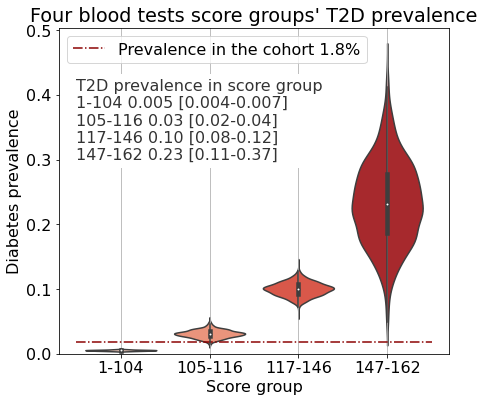

In [37]:
title= "Four blood tests score groups' T2D prevalence"
font = {'family' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")

# sns.violinplot(x="Boundaries", y="Ratio", data=test_rank1K, palette="Greens")
ax = sns.violinplot(x="Boundaries", data=test_rank1K, y="Ratio",palette="Reds",scale="width")
# Add in points to show each observation
# sns.stripplot(x="Boundaries", y="Ratio", data=test_rank1K,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Diabetes prevalence",xlabel="Score group")
# sns.despine(trim=True, left=True)
# ax.legend(new_stats_df.Legend,title="T2D prevalence in score group")
text_list="\n".join(list(new_stats_df.Legend.values))
text_list="T2D prevalence in score group\n"+text_list
ax.text(-0.5, 0.3, text_list,fontsize=16,backgroundcolor='white',alpha=0.8)
test_scores_prev=test_scores.y_test.sum()/test_scores.y_test.count()
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
ymin=0
ax.set_ylim(ymin,ymax)
ax.hlines(y=test_scores_prev,xmin=xmin,xmax=xmax,linestyles="-.",colors="darkred",
          label="Prevalence in the cohort "+"{:.1f}".format(100*test_scores_prev)+"%")
plt.legend(loc="upper left")
ax.set_title(title)
plt.savefig(os.path.join(curr_folder,scoreboard_type+"_groups_prevalence.jpeg"))
plt.show()

In [38]:
os.path.join(curr_folder,scoreboard_type+"_groups_prevalence.jpeg")

'/net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_No_reticulocytes_scoreboard/No_reticulocytes_scoreboard_groups_prevalence.jpeg'

# Calculate Five Blood tests

In [39]:
scoreboard_type="Five_blood"
# run_name="LR_No_reticulocytes_scoreboard"

sb=recover_scoreboard(scoreboard_type=scoreboard_type,
                      save_to_scoreboards_basic_path=results_path,
                      base_path=base_path)

sb.woe_csv_path=os.path.join(results_path,sb.run_name,"summary_files/woe_csv.csv")
sb.save_to_folder=os.path.join(results_path,sb.run_name)
sb.summary_folder=os.path.join(results_path,sb.run_name,"summary_files/")

Factor: 14.43 Offset: 43.56
('Running in ', 'None', ' mode')
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/ exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_Five_blood_tests_scoreboard/training_Results exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_Five_blood_tests_scoreboard/CI exists
('Running in ', 'None', ' mode')
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/Compare_singles_LR/ exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/Compare_singles_LR/LR_Five_Blood_Tests/training_Results exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/Compare_singles_LR/LR_Five_Blood_Tests/CI exists
Loading ScoreBoard Five_blood  from  /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_Five_blo

In [40]:
curr_folder=os.path.join(base_path,"results_folder", sb.run_name)
val_df,val_scores=load_labels(sb,y_file_name="y_LR_val.csv",curr_folder=curr_folder,mode="explore",return_results=True)
test_df,test_scores=load_labels(sb,y_file_name="y_LR_test.csv",curr_folder=curr_folder,mode=None,return_results=True)

In [41]:
n_bins=100
res=1./n_bins
quants_bins=[0.8,0.9,0.995,1]
val_Rank_df=pd.DataFrame()
val_Rank_df=calc_Rank_df(val_scores, quants_bins=quants_bins, prevalence_thresh_fold=None,pred_col="y_pred")
val_Rank_df

,quantile number,Lower Boundary,upper Boundary,Diagnosed,All,Ratio,Fold
0,1,0.000,100.000,50.0,8606.0,0.005810,1.000000
1,2,100.000,112.000,34.0,1052.0,0.032319,5.562814
2,3,112.000,141.385,109.0,1012.0,0.107708,18.538617
3,4,141.385,153.000,13.0,54.0,0.240741,41.436296


In [42]:
boundaries=[0]
boundaries.extend(val_Rank_df.loc[:,["upper Boundary"]].values.flatten().tolist())
val_rank_list=[]
for ind in np.arange(1000):
    sampled_val_scores=val_scores.sample(n=val_scores.shape[0],replace=True)
    val_rank_list.append(test_rank_df(sampled_val_scores, boundaries=boundaries,pred_col="y_pred"))
val_rank1K=pd.concat(val_rank_list)
val_rank1K["Boundaries"]=(val_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+val_rank1K["upper Boundary"].astype(int).astype(str)
val_rank1K.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(val_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_results.csv"))
new_stats_df

,mean,0.0275,0.975,CI,Legend
Boundaries,,,,,
1-100,0.006,0.004,0.008,0.006 [0.004-0.008],1-100 0.006 [0.004-0.008]
101-112,0.03,0.02,0.04,0.03 [0.02-0.04],101-112 0.03 [0.02-0.04]
113-141,0.11,0.09,0.13,0.11 [0.09-0.13],113-141 0.11 [0.09-0.13]
142-153,0.24,0.14,0.36,0.24 [0.14-0.36],142-153 0.24 [0.14-0.36]


## Test's bins result

In [43]:
test_rank_list=[]
for ind in np.arange(1000):
    sampled_test_scores=test_scores.sample(n=test_scores.shape[0],replace=True)
    test_rank_list.append(test_rank_df(sampled_test_scores, boundaries=boundaries,pred_col="y_pred"))

In [44]:
test_rank1K=pd.concat(test_rank_list)
test_rank1K["Boundaries"]=(test_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+test_rank1K["upper Boundary"].astype(int).astype(str)
test_rank1K.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(test_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_results.csv"))
new_stats_df

,mean,0.0275,0.975,CI,Legend
Boundaries,,,,,
1-100,0.005,0.004,0.007,0.005 [0.004-0.007],1-100 0.005 [0.004-0.007]
101-112,0.03,0.02,0.04,0.03 [0.02-0.04],101-112 0.03 [0.02-0.04]
113-141,0.10,0.08,0.12,0.10 [0.08-0.12],113-141 0.10 [0.08-0.12]
142-153,0.17,0.07,0.29,0.17 [0.07-0.29],142-153 0.17 [0.07-0.29]


In [45]:
## Plot whiskers

In [46]:
test_scores_prev=test_scores.y_test.sum()/test_scores.y_test.count()
test_scores_prev

0.01796875

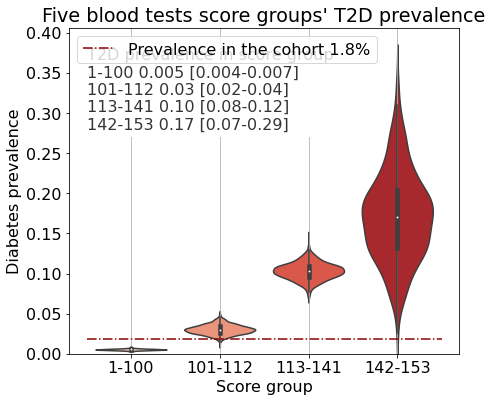

In [47]:
title= "Five blood tests score groups' T2D prevalence"
font = {'family' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")

# sns.violinplot(x="Boundaries", y="Ratio", data=test_rank1K, palette="Greens")
ax = sns.violinplot(x="Boundaries", data=test_rank1K, y="Ratio",palette="Reds",scale="width")
# Add in points to show each observation
# sns.stripplot(x="Boundaries", y="Ratio", data=test_rank1K,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Diabetes prevalence",xlabel="Score group")
# sns.despine(trim=True, left=True)
# ax.legend(new_stats_df.Legend,title="T2D prevalence in score group")
# prevalence_text="T2D prevalence in cohort "+"{:.3f}".format(test_scores_prev)+"\n"
text_list="\n".join(list(new_stats_df.Legend.values))
text_list="T2D prevalence in score group\n"+text_list
ax.text(-0.5, 0.28, text_list,fontsize=16,backgroundcolor='white',alpha=0.8)
test_scores_prev=test_scores.y_test.sum()/test_scores.y_test.count()
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
ymin=0
ax.set_ylim(ymin,ymax)
ax.hlines(y=test_scores_prev,xmin=xmin,xmax=xmax,linestyles="-.",colors="darkred",
          label="Prevalence in the cohort "+"{:.1f}".format(100*test_scores_prev)+"%")
plt.legend(loc="upper left")
ax.set_title(title)
plt.savefig(os.path.join(curr_folder,scoreboard_type+"_groups_prevalence.jpeg"))
plt.show()

# Calculate Anthropometrics

In [48]:
curr_folder_anthro=os.path.join(base_path, 'LR_Anthro_scoreboard')
scoreboard_anthro_type="Anthro"
sb_anthro=recover_scoreboard(scoreboard_anthro_type,save_to_scoreboards_basic_path=results_path,
                      base_path=base_path)

Factor: 14.43 Offset: 43.56
('Running in ', 'None', ' mode')
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/ exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_Anthro_scoreboard/training_Results exists
checking if /net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Revision_runs/results_folder/LR_Anthro_scoreboard/CI exists
Model:LR_Antro_neto_whr was not found in CI_configs
('Running in ', 'None', ' mode')


AttributeError: 'runs' object has no attribute 'model_type'

In [ ]:
val_df,val_scores=load_labels(sb_anthro,y_file_name="y_LR_val.csv",curr_folder=curr_folder,mode="explore",return_results=True)
test_df,test_scores=load_labels(sb_anthro,y_file_name="y_LR_test.csv",curr_folder=curr_folder,mode=None,return_results=True)

In [ ]:
n_bins=100
res=1./n_bins
quants_bins=[0.85,0.95,1]
val_Rank_df=pd.DataFrame()
val_Rank_df=calc_Rank_df(val_scores, quants_bins=quants_bins, prevalence_thresh_fold=None,pred_col="y_pred")
val_Rank_df

In [ ]:
boundaries=[0]
boundaries.extend(val_Rank_df.loc[:,["upper Boundary"]].values.flatten().tolist())
val_rank_list=[]
for ind in np.arange(1000):
    sampled_val_scores=val_scores.sample(n=val_scores.shape[0],replace=True)
    val_rank_list.append(test_rank_df(sampled_val_scores, boundaries=boundaries,pred_col="y_pred"))
val_rank1K=pd.concat(val_rank_list)
val_rank1K["Boundaries"]=(val_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+val_rank1K["upper Boundary"].astype(int).astype(str)
val_rank1K.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(val_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_results.csv"))
new_stats_df

In [ ]:
test_rank_list=[]
for ind in np.arange(1000):
    sampled_test_scores=test_scores.sample(n=test_scores.shape[0],replace=True)
    test_rank_list.append(test_rank_df(sampled_test_scores, boundaries=boundaries,pred_col="y_pred"))

In [ ]:
test_rank1K=pd.concat(test_rank_list)
test_rank1K["Boundaries"]=(test_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+test_rank1K["upper Boundary"].astype(int).astype(str)
test_rank1K.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(test_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_results.csv"))

In [ ]:
new_stats_df

In [ ]:
title= "Anthropometrics score groups' T2D prevalence"
font = {'family' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)
test_scores_prev=test_scores.y_test.sum()/test_scores.y_test.count()
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")

# sns.violinplot(x="Boundaries", y="Ratio", data=test_rank1K, palette="Greens")
ax = sns.violinplot(x="Boundaries", data=test_rank1K, y="Ratio",palette="Greens",scale="width")
# Add in points to show each observation
# sns.stripplot(x="Boundaries", y="Ratio", data=test_rank1K,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Diabetes prevalence",xlabel="Score group")
# sns.despine(trim=True, left=True)
# ax.legend(new_stats_df.Legend,title="T2D prevalence in score group")
text_list="\n".join(list(new_stats_df.Legend.values))
text_list="T2D prevalence in score group\n"+text_list
ax.text(-0.55, 0.097, text_list,fontsize=16,backgroundcolor='white',alpha=0.8)
ax.set_title(title)
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
ymin=0
ax.set_ylim(ymin,ymax)
ax.hlines(y=test_scores_prev,xmin=xmin,xmax=xmax,linestyles="-.",colors="darkgreen",
          label="Prevalence in the cohort "+"{:.1f}".format(100*test_scores_prev)+"%")
plt.legend(loc="upper left")
plt.savefig(os.path.join(curr_folder_anthro,scoreboard_anthro_type+"_groups_prevalence.jpeg"))
plt.show()